In [77]:
#Python Final Capstone Project


#imports
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from io import BytesIO
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split

C:\Users\sanjiv\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#reading the csv from a sharable link

#football=requests.get("https://drive.google.com/file/d/1-DsD-gwN5JR3Cd7algCHh0bJCIiqaVAa/view?usp=sharing")
#data=football.content
#footballEvents=pd.read_csv(BytesIO(data),error_bad_lines=False)

events=pd.read_csv("https://www.dropbox.com/s/fobrl0xvjc9fq03/events.csv?dl=1")
league=pd.read_csv("https://www.dropbox.com/s/4qjfstyxqw1uu83/ginf.csv?dl=1")

In [3]:
league.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


In [4]:
footballEvents=pd.merge(events,league[['id_odsp','league','season','country']],how='left',on='id_odsp')
#We perform a left join to make sure that all the match with events described in them are analyzed.
#This would avoid us analyzing the matches which have no events mentioned in detail.

In [5]:
footballEvents.info()
encoding=pd.read_table("https://www.dropbox.com/s/fgwtjam3c9mfm2c/FootballDictionary.txt?dl=1", delim_whitespace=False, names=('num','events'))
event_type=encoding[1:13]
event_type_2=encoding[14:18]
side=encoding[19:21]
shot_place=encoding[22:35]
shot_outcome=encoding[36:40]
location=encoding[41:60]
bodypart=encoding[61:64]
assist_method=encoding[65:70]
situition=encoding[71:75]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 25 columns):
id_odsp          941009 non-null object
id_event         941009 non-null object
sort_order       941009 non-null int64
time             941009 non-null int64
text             941009 non-null object
event_type       941009 non-null int64
event_type2      214293 non-null float64
side             941009 non-null int64
event_team       941009 non-null object
opponent         941009 non-null object
player           880009 non-null object
player2          291310 non-null object
player_in        51715 non-null object
player_out       51738 non-null object
shot_place       227459 non-null float64
shot_outcome     228498 non-null float64
is_goal          941009 non-null int64
location         467067 non-null float64
bodypart         229185 non-null float64
assist_method    941009 non-null int64
situation        229137 non-null float64
fast_break       941009 non-null int64
league      

In [6]:
footballEvents.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,league,season,country
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,2.0,0,9.0,2.0,1,1.0,0,D1,2012,germany
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,0,NaN,NaN,0,NaN,0,D1,2012,germany
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,0,NaN,NaN,0,NaN,0,D1,2012,germany
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,0,NaN,NaN,0,NaN,0,D1,2012,germany
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,0,2.0,NaN,0,NaN,0,D1,2012,germany


In [7]:
league.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


Details of the numbers indicated in each column

In [8]:
event_type

,num,events
1,0,Announcement
2,1,Attempt
3,2,Corner
4,3,Foul
5,4,Yellow card
6,5,Second yellow card
7,6,Red card
8,7,Substitution
9,8,Free kick won
10,9,Offside


In [9]:
event_type_2

,num,events
14,12,Key Pass
15,13,Failed through ball
16,14,Sending off
17,15,Own goal


In [10]:
side

,num,events
19,1,Home
20,2,Away


In [11]:
shot_place

,num,events
22,1,Bit too high
23,2,Blocked
24,3,Bottom left corner
25,4,Bottom right corner
26,5,Centre of the goal
27,6,High and wide
28,7,Hits the bar
29,8,Misses to the left
30,9,Misses to the right
31,10,Too high


In [12]:
shot_outcome

,num,events
36,1,On target
37,2,Off target
38,3,Blocked
39,4,Hit the bar


In [13]:
location

,num,events
41,1,Attacking half
42,2,Defensive half
43,3,Centre of the box
44,4,Left wing
45,5,Right wing
46,6,Difficult angle and long range
47,7,Difficult angle on the left
48,8,Difficult angle on the right
49,9,Left side of the box
50,10,Left side of the six yard box


In [14]:
bodypart

,num,events
61,1,right foot
62,2,left foot
63,3,head


In [15]:
assist_method

,num,events
65,0,None
66,1,Pass
67,2,Cross
68,3,Headed pass
69,4,Through ball


In [16]:
#Setpiece in 2, does not include free kick which is mentioned in 4
situition
footballEvents.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,league,season,country
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,2.0,0,9.0,2.0,1,1.0,0,D1,2012,germany
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,0,NaN,NaN,0,NaN,0,D1,2012,germany
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,0,NaN,NaN,0,NaN,0,D1,2012,germany
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,0,NaN,NaN,0,NaN,0,D1,2012,germany
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,0,2.0,NaN,0,NaN,0,D1,2012,germany


# 1) Analysing the goals

In [17]:
goals=footballEvents[footballEvents["is_goal"]==1]
goals.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,league,season,country
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,...,1.0,1,9.0,2.0,1,1.0,0,D1,2012,germany
26,UFot0hit/,UFot0hit27,27,29,"Goal! Borussia Dortmund 2, Hamburg 0. Mario G...",1,12.0,1,Borussia Dortmund,Hamburg SV,...,1.0,1,3.0,1.0,1,1.0,0,D1,2012,germany
50,UFot0hit/,UFot0hit51,51,49,"Goal! Borussia Dortmund 3, Hamburg 0. Kevin G...",1,NaN,1,Borussia Dortmund,Hamburg SV,...,1.0,1,13.0,1.0,0,3.0,0,D1,2012,germany
92,UFot0hit/,UFot0hit93,93,80,"Goal! Borussia Dortmund 3, Hamburg 1. Robert ...",1,NaN,2,Hamburg SV,Borussia Dortmund,...,1.0,1,3.0,2.0,0,3.0,0,D1,2012,germany
175,Aw5DflLH/,Aw5DflLH66,66,48,"Goal! FC Augsburg 0, SC Freiburg 1. Papiss De...",1,12.0,2,SC Freiburg,FC Augsburg,...,1.0,1,15.0,1.0,1,1.0,1,D1,2012,germany


Text(0.5,1,'Number of goals against Time during match')

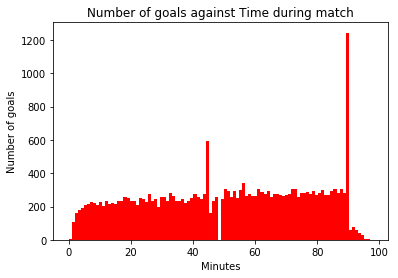

In [18]:
#plt.xlabel("Goals scored from")
#plt.ylabel("League")
#plt.show


plt.hist(goals.time,width=1,bins=100,color="red")   #100 so 1 bar per minute
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.title("Number of goals against Time during match")

## We can see from the above plot that most of the goals are scored at the end of both the halves. This can be due to urgency in play when the scores are tied or when a team is trailing.

In [43]:
#b=goals.plot.bar('is_goal','bodypart',color='red',rot=0)

#goals.groupby('bodypart').plot.barh()

In [44]:
#pie=goals.plot.pie(y='bodypart',figsize(5,5))

Text(0.5,1,'Number of goals (by home/away side) against Time during match')

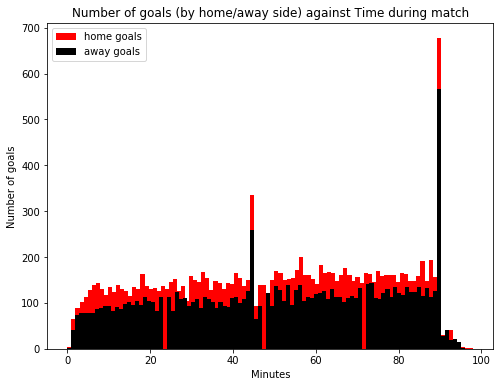

In [45]:
fig=plt.figure(figsize=(8,6))
plt.hist(goals[goals["side"]==1]["time"],width=1,bins=100,color="red",label="home goals")   
plt.hist(goals[goals["side"]==2]["time"],width=1,bins=100,color="black",label="away goals") 
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.legend()
plt.title("Number of goals (by home/away side) against Time during match")

C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning

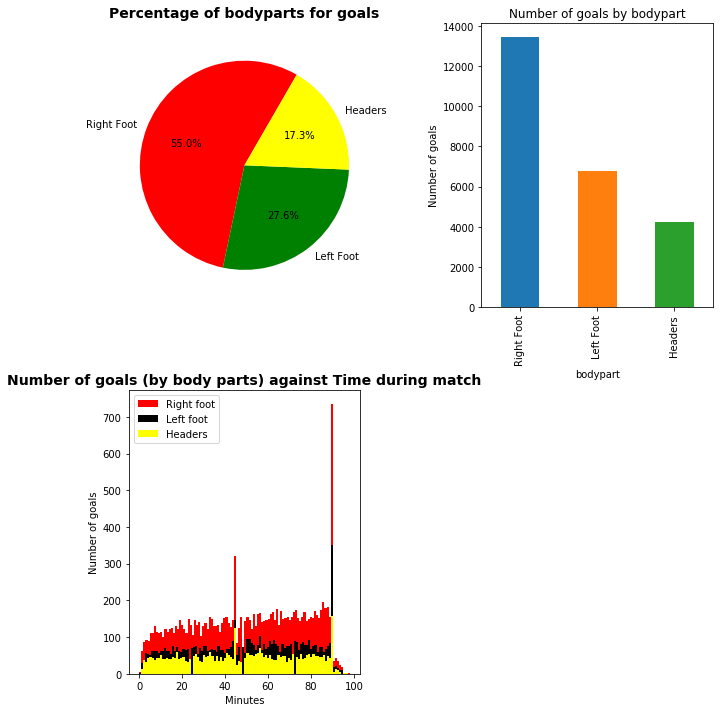

In [46]:
plt.subplot(2,2,1)
labels=["Right Foot","Left Foot","Headers"]
sizes=[goals[goals["bodypart"]==1].shape[0],goals[goals["bodypart"]==2].shape[0],goals[goals["bodypart"]==3].shape[0]]
colors=["red","green","yellow"]
plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=60)
plt.axis('equal')
plt.title("Percentage of bodyparts for goals",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
fig=plt.gcf() 
fig.set_size_inches(10,10)

plt.subplot(2,2,2)
plt.title("Number of goals by bodypart")
plt.ylabel("Number of goals")
goals.groupby('bodypart')['is_goal'].sum().plot.bar()
plt.xticks(np.arange(3),("Right Foot","Left Foot","Headers"))


plt.subplot(2,2,3)
plt.hist(goals[goals["bodypart"]==1]["time"],width=1,bins=100,color="red",label="Right foot")   
plt.hist(goals[goals["bodypart"]==2]["time"],width=1,bins=100,color="black",label="Left foot") 
plt.hist(goals[goals["bodypart"]==3]["time"],width=1,bins=100,color="yellow",label="Headers") 
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.legend()
plt.title("Number of goals (by body parts) against Time during match",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
plt.tight_layout()


# In the above plot, we can see that there are more than double the amount of right footed goals as compared to the left footed ones which come in second. Headers are the third in order. 

C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning

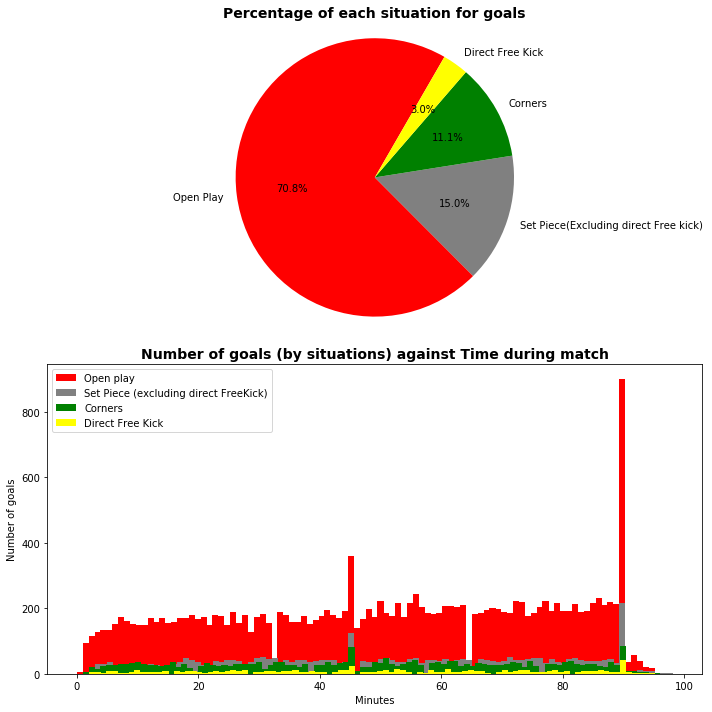

In [23]:
plt.subplot(2,1,1)
labels=["Open Play", "Set Piece(Excluding direct Free kick)","Corners","Direct Free Kick"]
sizes=[goals[goals["situation"]==1].shape[0],goals[goals["situation"]==2].shape[0],goals[goals["situation"]==3].shape[0],goals[goals["situation"]==4].shape[0]]
colors=["red","grey","green","yellow"]
plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=60)
plt.axis('equal')
plt.title("Percentage of each situation for goals",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
fig=plt.gcf() 
fig.set_size_inches(10,10)

plt.subplot(2,1,2)
plt.hist(goals[goals["situation"]==1]["time"],width=1,bins=100,color="red",label="Open play")   
plt.hist(goals[goals["situation"]==2]["time"],width=1,bins=100,color="grey",label="Set Piece (excluding direct FreeKick)") 
plt.hist(goals[goals["situation"]==3]["time"],width=1,bins=100,color="green",label="Corners") 
plt.hist(goals[goals["situation"]==4]["time"],width=1,bins=100,color="yellow",label="Direct Free Kick") 
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.legend()
plt.title("Number of goals (by situations) against Time during match",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
plt.tight_layout()

### We see above that open plays make up for most of the goals scored with set piece being more likely to result in a goal scored than a corner.

# We now remove the location that do not result in a goal. That will make sure that we do not take them into account while analyzing the goals scored.

In [47]:
for i in range(20):
    if sum(goals["location"]==i)==0:
        print(i)

0
1
2
4
5


C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning

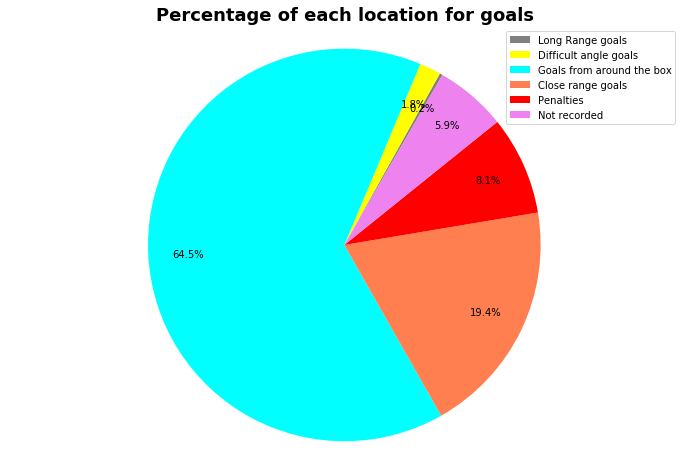

In [48]:
diff_angle_goals=sum(goals["location"]==6)+sum(goals["location"]==7)+sum(goals["location"]==8)
long_range_goals=sum(goals["location"]==16)+sum(goals["location"]==17)+sum(goals["location"]==18)
box_goals=sum(goals["location"]==3)+sum(goals["location"]==9)+sum(goals["location"]==11)+sum(goals["location"]==15)
close_range_goals=sum(goals["location"]==10)+sum(goals["location"]==12)+sum(goals["location"]==13)
penalties=sum(goals["location"]==14)
not_recorded=sum(goals["location"]==19)

labels=["Long Range goals","Difficult angle goals","Goals from around the box","Close range goals","Penalties","Not recorded"]
sizes=[long_range_goals,diff_angle_goals,box_goals,close_range_goals,penalties,not_recorded]
colors=["gray","yellow","aqua","coral","red","violet"]
plt.pie(sizes,colors=colors,autopct='%1.1f%%',startangle=60,pctdistance=0.8,radius=3)
plt.axis('equal')
plt.title("Percentage of each location for goals",fontname="Times New Roman Bold",fontsize=18,fontweight="bold")
plt.legend(labels)
fig=plt.gcf() 
fig.set_size_inches(12,8)
plt.show()

C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\sanjiv\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning

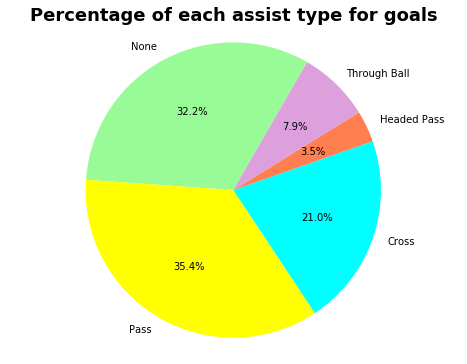

In [49]:
labels=["None","Pass","Cross","Headed Pass","Through Ball"]
sizes=[sum(goals["assist_method"]==0),sum(goals["assist_method"]==1),sum(goals["assist_method"]==2),sum(goals["assist_method"]==3),sum(goals["assist_method"]==4)]
colors=["palegreen","yellow","aqua","coral","plum"]
plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=60)
plt.axis('equal')
plt.title("Percentage of each assist type for goals",fontname="Times New Roman Bold",fontsize=18,fontweight="bold")
fig=plt.gcf()  #gcf --> current figure
fig.set_size_inches(8,6)
plt.show()

# Predicting the outcome of the future matches

In [65]:
x_var=league.iloc[:,9:14]
x_var.head()

def actual_result(fthg,ftag):
    if fthg>ftag:
        return("Home Win")
    elif fthg==ftag:
        return("Draw")
    elif fthg<ftag:
        return("Away Win")
    
def actual_result_encode(fthg,ftag):
    if fthg>ftag:
        return (1)
    elif fthg==ftag:
        return (2)
    elif fthg<ftag:
        return (3)
    
def acc_score(model):
    return np.mean(cross_val_score(model,x_train,y_train,cv=k_fold,scoring="accuracy"))

def norm_score(model):
    return (accuracy_score(y_train,model.predict(x_train)))

In [66]:
x_var=league.iloc[:,9:14]
result=[]
for i in range(1,league.shape[0]+1):
    result.append(actual_result_encode(league[i-1:i]["fthg"].item(),league[i-1:i]["ftag"].item()))
y=pd.DataFrame(result)
x_var["diff_h_d"]=abs(x_var["odd_h"]-x_var["odd_d"])
x_var["diff_d_a"]=abs(x_var["odd_d"]-x_var["odd_a"])
x_var["diff_h_a"]=abs(x_var["odd_h"]-x_var["odd_a"])
x_var=x_var.drop(["fthg","ftag"],axis=1)
x_var.tail()



,odd_h,odd_d,odd_a,diff_h_d,diff_d_a,diff_h_a
10107,1.97,4.35,8.0,2.38,3.65,6.03
10108,1.19,8.50,20.0,7.31,11.50,18.81
10109,1.32,6.24,11.5,4.92,5.26,10.18
10110,1.74,4.07,5.9,2.33,1.83,4.16
10111,1.79,3.96,5.4,2.17,1.44,3.61


In [79]:
x_train,x_test,y_train,y_test=train_test_split(x_var,y,test_size=0.2,random_state=0)
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [80]:
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_train,model_used.predict(x_train))
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Home Win","Predicted Draw","Predicted Away Win"]
    cm.index=["Actual Home Win","Actual Draw","Actual Away Win"]
    return cm

In [81]:
log_reg=LogisticRegression()
log_reg.fit(x_train,y_train)
print("Logistic Regression Accuracy (without cross validation): "+str(norm_score(log_reg)))
print("Logistic Regression Cross Validation Accuracy: "+str(acc_score(log_reg)))
confusion_matrix_model(log_reg)

C:\Users\sanjiv\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy (without cross validation): 0.5278773643219187


C:\Users\sanjiv\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanjiv\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanjiv\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanjiv\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Logistic Regression Cross Validation Accuracy: 0.5270124772056934


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3237,1,486
Actual Draw,1548,0,506
Actual Away Win,1278,0,1033


## Above, we can see that the predicted home win was in 6063 matches in total, out of which 3237 matches were won by the home team.
## The predicted away win was in 2025 matches in total, out of which 486 matches were won by the away team.

# We predicted the home team wins more accurately with the precision of 52.7%